# Face Recognition

# Tina Rezvanian

# 1. Do existing pretrained models correctly recognize faces in images?

We will use 2 pretrained models with vgg16 and resNet50 architectures that are trained on the VGGface2 data set. VGGFace2 dataset is developed by researchers at the Visual Geometry Group at Oxford, includes faces across different poses and ages. The dataset contains 3.31 million images of 9131 subjects (including actors, athletes, politicians), approximately 362 images for each subject. This two pretrained models (VGG16 and ResNnet50 trained on VGGFACE2 dataset) are available in package 'keras_vggface' available (https://github.com/rcmalli/keras-vggface). this data set has a 8631 to 500 train and validation split on the identities.

Input for this two models require a face detector. For that reason, I use the detector MTCNN in package mtcnn.mtcnn. The 'preprocess_input' function of the 'keras_vggface.utils' package is used to prepare the face to become the input of the models.(required size is 224 × 224 crop of the center face image is used as input to the network). The face descriptor or the embeddings is extracted from the layer adjacent to the classifier layer. This leads to a 2048 dimensional descriptor, which is then L2 normalized.



When specifying weights: one of None (random initialization) or "vggface" (pre-training on VGGFACE datasets). this work project only uses weight pretrained on 'vggface'.
This project uses the following dataset for prediction:



Selected 11 classes of celebrities in CASIA-WebFace publicly available dataset(here) This dataset is created by the Institute of Automation, Chinese Academy of Sciences (CASIA) gathered from IMDb profiles. Labels and image list of CASIA WebFace data set can be found here. CASIA WebFace Facial dataset includes 494,414 images over 10,575 identities and requires some filtering for quality. The number of images in each class averages 46 image per subject, however, for this project 11 classes with at least 180 images are selected.
- candidate images for prediction are in 'test_dir'


In [1]:
! pip show keras-vggface

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: /anaconda3/envs/DLpy37/lib/python3.7/site-packages
Requires: pyyaml, pillow, six, keras, numpy, h5py, scipy
Required-by: 


In [2]:
import keras_vggface
print(keras_vggface.__version__)

Using TensorFlow backend.


0.6


In [3]:
! python --version

Python 3.7.6


In [5]:
import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from numpy import expand_dims
from numpy import asarray
import pandas as pd
import seaborn as sns
from IPython import display
from PIL import Image
from IPython import display
import cv2
import keras_vggface
import keras
from keras import layers
from keras import models
from keras import regularizers
from keras import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model
from keras.layers import *
from keras.models import Sequential
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions
from keras import regularizers
from keras.utils import to_categorical
from mtcnn.mtcnn import MTCNN

In [10]:
IMG_SIZE  = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
required_size = (IMG_SIZE, IMG_SIZE)
# Tesing set
test_dir = 'keras-facenet/data/test'
listGroupsTest = os.listdir(test_dir) 
listGroupsTest = [f for f in listGroupsTest if not f.startswith('.')]
 listGroupsTest

['Teri_Hatcher',
 'Geena_Davis',
 'Neve_Campbell',
 'Kevin_Bacon',
 'Patricia_Arquette',
 'Steve_Buscemi',
 'Kim_Basinger',
 'David_Duchovny',
 'Helen_Hunt',
 'Colin_Firth',
 'Jeff_Goldblum']

In [114]:
required_size = (IMG_SIZE, IMG_SIZE)

In [99]:
def extract_face(img_path, required_size=required_size):
    # load image from file
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # create detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(img_rgb)
    # extract the bounding box associated to larger area
    bigger_face = max(results, key=lambda b: b['box'][2] * b['box'][3])
    x1, y1, width, height = bigger_face['box']
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = img_rgb[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

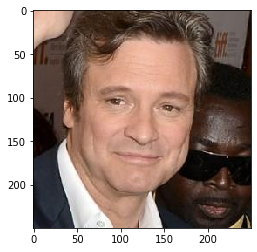

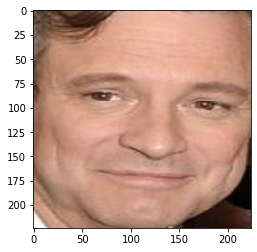

In [71]:
# example of face extraction:
img_path = 'Data/train/Colin_Firth/001.jpg'
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

face = extract_face(img_path)
plt.imshow(face)
plt.show()

# Predict using pretrained models:

In [11]:
def prepare_image_pretrained(img_path, img_size = IMG_SIZE):
    face = extract_face(img_path)
    face = face.astype('float32')
    face = expand_dims(face, axis=0)
    samples = keras_vggface.utils.preprocess_input(face, version=2)
    return samples


def faceClassifier_pretrained(model, imagePath):
    preprocessed_image = prepare_image_pretrained(imagePath)
    # Use pretrained model to classify the image
    predictions = model.predict(preprocessed_image)
    results = decode_predictions(predictions)  
    return results

In [12]:
def faceRecognition_pretrained(model, test_dir):    
    predictions_list=[]
    for celeb in os.listdir(test_dir):
        if not celeb.startswith('.'):
            test_img_path = os.path.join(test_dir, celeb)
            if not test_img_path.startswith('.'):
                for test_img  in os.listdir(test_img_path):
                    if not test_img.startswith('.'):
                        fullimagepath = os.path.join(test_img_path, test_img)
                        face = prepare_image_pretrained(fullimagepath)
                        predictions = model.predict(face)
                        predictions_list.append(predictions)
                predictions = np.sum(predictions_list, axis=0)
                top_pred = decode_predictions(predictions) 
            print('Test picture from: ', celeb,':\n Prediction: ' ,top_pred, '\n')

# VGG16

In [13]:
# Lets predict using exisiting pretrained vgg16 model 
vgg16 = VGGFace(model='vgg16')
faceRecognition_pretrained(vgg16, test_dir)

Test picture from:  Teri_Hatcher :
 Prediction:  [[["b'Teri_Hatcher'", 0.53289264], ["b'Marina_Sirtis'", 0.034269728], ["b'Marisol_Nichols'", 0.020355703], ["b'Bahar_Soomekh'", 0.016289664], ["b'Tamara_Feldman'", 0.014841828]]] 

Test picture from:  Geena_Davis :
 Prediction:  [[["b'Geena_Davis'", 0.97315073], ["b'Teri_Hatcher'", 0.53289354], ["b'Marina_Sirtis'", 0.034270935], ["b'Marisol_Nichols'", 0.020357871], ["b'Bahar_Soomekh'", 0.016321553]]] 

Test picture from:  Neve_Campbell :
 Prediction:  [[["b'Neve_Campbell'", 0.998247], ["b'Geena_Davis'", 0.97315073], ["b'Teri_Hatcher'", 0.53289366], ["b'Marina_Sirtis'", 0.03427095], ["b'Marisol_Nichols'", 0.02035795]]] 

Test picture from:  Kevin_Bacon :
 Prediction:  [[["b'Neve_Campbell'", 0.9982632], ["b'Geena_Davis'", 0.9731526], ["b'Kevin_Bacon'", 0.62608254], ["b'Teri_Hatcher'", 0.5328978], ["b'Marina_Sirtis'", 0.034274735]]] 

Test picture from:  Patricia_Arquette :
 Prediction:  [[["b'Neve_Campbell'", 0.998648], ["b'Geena_Davis'", 

In [16]:
vgg16.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)     

# ResNet50

In [14]:
# Lets predict using exisiting pretrained resnet50 model 
resnet50 = VGGFace(model='resnet50')
faceRecognition_pretrained(resnet50, test_dir)

Test picture from:  Teri_Hatcher :
 Prediction:  [[["b' Ay\\xc5\\x9feg\\xc3\\xbcl_Aldin\\xc3\\xa7'", 0.17874312], ["b' Peggy_Lipton'", 0.08712374], ["b' Valeria_Solarino'", 0.028685542], ["b' Micaela_Ramazzotti'", 0.027750503], ["b' Lana_Parrilla'", 0.02382494]]] 

Test picture from:  Geena_Davis :
 Prediction:  [[["b' Ay\\xc5\\x9feg\\xc3\\xbcl_Aldin\\xc3\\xa7'", 0.17875075], ["b' Melissa_Sagemiller'", 0.102681205], ["b' Peggy_Lipton'", 0.08717244], ["b' Stefanie_Stappenbeck'", 0.03472344], ["b' Dedee_Pfeiffer'", 0.032279067]]] 

Test picture from:  Neve_Campbell :
 Prediction:  [[["b' Raquel_S\\xc3\\xa1nchez-Silva'", 0.20582676], ["b' Ay\\xc5\\x9feg\\xc3\\xbcl_Aldin\\xc3\\xa7'", 0.17900482], ["b' Ana_Claudia_Talanc\\xc3\\xb3n'", 0.14541118], ["b' Natasza_Urba\\xc5\\x84ska'", 0.10859329], ["b' Melissa_Sagemiller'", 0.10268208]]] 

Test picture from:  Kevin_Bacon :
 Prediction:  [[["b' Raquel_S\\xc3\\xa1nchez-Silva'", 0.20582817], ["b' Ay\\xc5\\x9feg\\xc3\\xbcl_Aldin\\xc3\\xa7'", 0.1790

In [15]:
resnet50.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_38[0][0]                   
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

# Report: 

Pretrained models performance:
- Although pretrained models include the classes asssociated to selected subjects, they do not do a good job in predicting them.

- VGG15 predicts only 3 our of the 11 pictures in the tes_dir, where as the Resnet50 None of them.

# 2. How to improve performance of existing pretrained models using deep learning techniques?


Some explanation on the namings:


    -conv_base is used to expleain that it respresents the convolutional base  and does not have the top layer
    
    -FE used to specify the object is used in the Feature Extraction 
    
    -TL used to specify the object is used in the Transfer Learning 
    
    -FT used to specify the object is used in the Fine Tuning 

#  Feature Extract (FE):

Extract features and labels in train, validation, and test folders by predicting from the convolutional base of the pretrained models Created Models using Extracted Features from Convolutional Base of VGG16 and ResNet50 Reshape them to be inputted into a model with dense layers Use dropouts and regularizes for regularization to avoid overfitting.


In [101]:
# create a plot function to avoid rewriting:

In [17]:
def plot_history(history, title, clr1='blue', clr2='green'):
  # helper function to plot the loss and accuracy 
    plt.figure(figsize=(18, 7))
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.suptitle('Categorical Plotting')

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(acc)+1), acc, color=clr1, label='Training Accuracy ' )
    plt.plot(range(1, len(acc)+1), val_acc, color=clr2, linestyle='dashed', label='Validation Accuracy' )
    plt.legend()
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(acc)+1), loss, color=clr1,  label='Training Loss ')
    plt.plot(range(1, len(acc)+1), val_loss, color=clr2, linestyle='dashed', label='Validation Loss')
    plt.legend()
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.suptitle(title)
    plt.show()

# Loading the convolutional base of model VGG16  for FE:

In [108]:
conv_base_vgg16_FE = VGGFace(input_shape=IMG_SHAPE,model='vgg16',weights='vggface',include_top=False)

In [110]:
conv_base_vgg16_FE.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_288 (InputLayer)       (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)     

Extract features and labels:
for train validation and test, and reshape them to get prepared for the required input dimension      for a model with dense layers: (input_dim=7 * 7 * 512)


In [104]:
base_dir = 'Data'
test_dir = 'keras-facenet/data/test'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features_vgg16(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='sparse')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base_vgg16_FE.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1

        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

#  extract the features 
train_features_vgg16, train_labels_vgg16 = extract_features_vgg16(train_dir, 2142)
validation_features_vgg16, validation_labels_vgg16 = extract_features_vgg16(validation_dir, 1089)
test_features_vgg16, test_labels_vgg16 = extract_features_vgg16(test_dir, 11)


train_features_vgg16 = np.reshape(train_features_vgg16, (2142, 7*7* 512))
validation_features_vgg16= np.reshape(validation_features_vgg16, (1089, 7* 7* 512))
test_features_vgg16 = np.reshape(test_features_vgg16, (11, 7* 7* 512))

Found 2142 images belonging to 11 classes.
Found 1089 images belonging to 11 classes.
Found 11 images belonging to 11 classes.


In [20]:
vgg16_FE = keras.models.Sequential()
vgg16_FE.add(keras.layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
vgg16_FE.add(keras.layers.Dropout(0.5))
vgg16_FE.add(keras.layers.Dense(128, activation='relu'))
vgg16_FE.add(keras.layers.Dropout(0.5))
vgg16_FE.add(keras.layers.Dense(11, activation='softmax'))

#compile model
vgg16_FE.compile(optimizer=keras.optimizers.Adam(lr=2e-2),
              loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#  fit model using 20 epochs
history_vgg16_FE= vgg16_FE.fit(train_features_vgg16, train_labels_vgg16,
                    epochs=20,
                    batch_size=20,
                    validation_data=(validation_features_vgg16, validation_labels_vgg16))

Train on 2142 samples, validate on 1089 samples
Epoch 1/20
2142/2142 [==============================] - 8s 4ms/step - loss: 3.7787 - accuracy: 0.9916 - val_loss: 2.8267 - val_accuracy: 0.9826
Epoch 2/20
2142/2142 [==============================] - 7s 3ms/step - loss: 1.4461 - accuracy: 0.9907 - val_loss: 3.1294 - val_accuracy: 0.9844
Epoch 3/20
2142/2142 [==============================] - 7s 3ms/step - loss: 3.6255 - accuracy: 0.9855 - val_loss: 1.6346 - val_accuracy: 0.9881
Epoch 4/20
2142/2142 [==============================] - 7s 3ms/step - loss: 3.8657 - accuracy: 0.9911 - val_loss: 3.0933 - val_accuracy: 0.9826
Epoch 5/20
2142/2142 [==============================] - 7s 3ms/step - loss: 1.9335 - accuracy: 0.9921 - val_loss: 0.5237 - val_accuracy: 0.9835
Epoch 6/20
2142/2142 [==============================] - 7s 3ms/step - loss: 1.1917 - accuracy: 0.9916 - val_loss: 1.3274 - val_accuracy: 0.9826
Epoch 7/20
2142/2142 [==============================] - 7s 3ms/step - loss: 0.9990 - acc

In [21]:
vgg16_FE.save('vgg16_FE.h5')

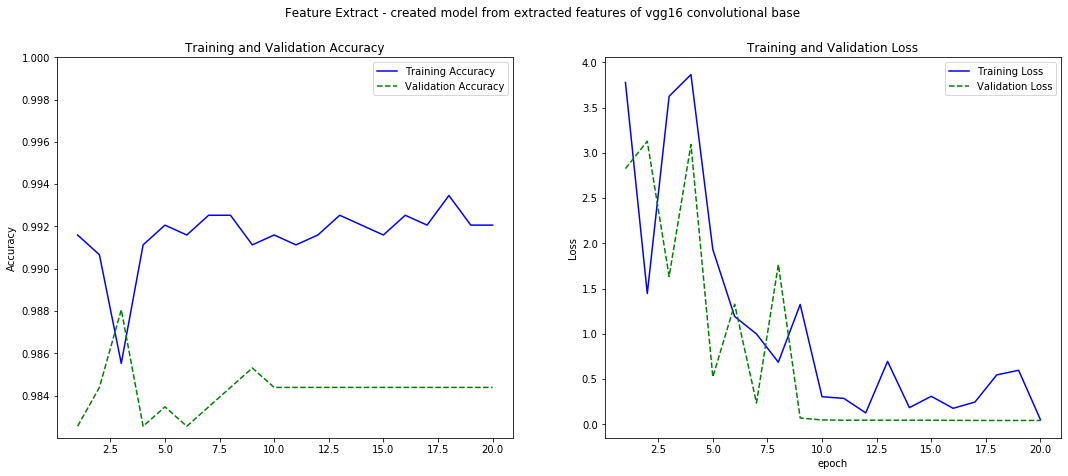

In [22]:
plot_history(history_vgg16_FE, 'Feature Extract - created model from extracted features of vgg16 convolutional base')

# Loading the convolutional base of model resnet50 for FE

In [24]:
conv_base_resnet50_FE = VGGFace(input_shape=IMG_SHAPE,model='resnet50',weights='vggface',include_top=False)

In [105]:
base_dir = 'Data'
test_dir = 'keras-facenet/data/test'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features_resnet50(directory, sample_count):
    features = np.zeros(shape=(sample_count, 1, 1, 2048))
    labels = np.zeros(shape=(sample_count))
    
#     Data Augmentation
    generator = datagen.flow_from_directory(
        directory,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='sparse')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base_resnet50_FE.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
                
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
#         print(inputs_batch, labels_batch )
        break
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features_resnet50, train_labels_resnet50 = extract_features_resnet50(train_dir, 2142)
validation_features_resnet50, validation_labels_resnet50 = extract_features_resnet50(validation_dir, 1089)
test_features_resnet50, test_labels_resnet50 = extract_features_resnet50(test_dir, 11)

Found 2142 images belonging to 11 classes.
Found 1089 images belonging to 11 classes.
Found 11 images belonging to 11 classes.


In [28]:
train_features_resnet50 = np.reshape(train_features_resnet50, (2142,  1 * 1 * 2048))
validation_features_resnet50 = np.reshape(validation_features_resnet50, (1089, 1 * 1 * 2048))
test_features_resnet50 = np.reshape(test_features_resnet50, (11, 1 * 1 * 2048))


In [29]:
resnet50_FE = keras.models.Sequential()
resnet50_FE.add(keras.layers.Dense(512, kernel_regularizer=regularizers.l2(lamb), activation='relu', input_dim=1 * 1 * 2048))
resnet50_FE.add(keras.layers.Dropout(0.5))
resnet50_FE.add(keras.layers.Dense(128, kernel_regularizer=regularizers.l2(lamb), activation='relu'))
resnet50_FE.add(keras.layers.Dropout(0.5))
resnet50_FE.add(keras.layers.Dense(11, activation='softmax'))

resnet50_FE.compile(optimizer=keras.optimizers.Adam(lr=2e-2),
              loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history_resnet50_FE = resnet50_FE.fit(train_features_resnet50, train_labels_resnet50,
                    epochs=20,
                    batch_size=20,
                    validation_data=(validation_features_resnet50, validation_labels_resnet50))

Train on 2142 samples, validate on 1089 samples
Epoch 1/20
2142/2142 [==============================] - 2s 867us/step - loss: 1.6240 - accuracy: 0.9916 - val_loss: 0.7360 - val_accuracy: 0.9862
Epoch 2/20
2142/2142 [==============================] - 2s 801us/step - loss: 0.4993 - accuracy: 0.9921 - val_loss: 0.3757 - val_accuracy: 0.9826
Epoch 3/20
2142/2142 [==============================] - 2s 784us/step - loss: 0.2959 - accuracy: 0.9921 - val_loss: 0.1765 - val_accuracy: 0.9862
Epoch 4/20
2142/2142 [==============================] - 2s 770us/step - loss: 0.1888 - accuracy: 0.9916 - val_loss: 0.2327 - val_accuracy: 0.9862
Epoch 5/20
2142/2142 [==============================] - 2s 774us/step - loss: 0.2349 - accuracy: 0.9921 - val_loss: 0.4435 - val_accuracy: 0.9862
Epoch 6/20
2142/2142 [==============================] - 2s 784us/step - loss: 0.5025 - accuracy: 0.9911 - val_loss: 0.3661 - val_accuracy: 0.9862
Epoch 7/20
2142/2142 [==============================] - 2s 784us/step - loss

In [30]:
resnet50_FE.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_165 (Dense)            (None, 512)               1049088   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_166 (Dense)            (None, 128)               65664     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_167 (Dense)            (None, 11)                1419      
Total params: 1,116,171
Trainable params: 1,116,171
Non-trainable params: 0
_________________________________________________________________


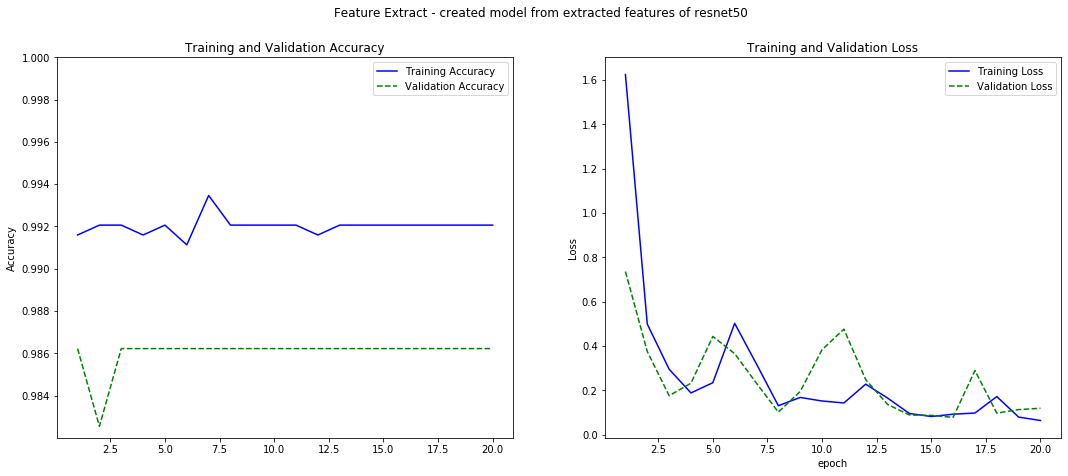

In [31]:
plot_history(history_resnet50_FE, 'Feature Extract - created model from extracted features of resnet50 ')

In [33]:
resnet50_FE.save('resnet50_FE_30epochs.h5')

# Report:
    
  - The accuracy of training and test remains almost constant through different epochs. Also the loss of training and validation becomes almost equal in 20 epochs. No need for training with more epochs.
  
  - The validation accuracy remains less that training, but they are close.

  - 20 epochs seems to be a good choice, accuracy has been constant and loss values are decreasing across both training and validation. 


# Transfer Learning (TL)

Build a model on top of the convolutional base of the VGG16 and ResNet50
Freeze the parameters of the convolutional base 
Train parameters in added dense and classification layers
Use dropouts and regularizes for regularization to avoid overfitting

#     Data Augmentation
- Images are augmented based on horizontal flip, 45 rotation, and zooming for training. The validation images are not augmented.


In [37]:
pathFolder = './Data/'
IMG_SIZE  = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

#  image augmentation

# We are getting our train_generator, validation_generator and test_generator ready :

train_datagen=ImageDataGenerator(preprocessing_function=keras_vggface.utils.preprocess_input,
                                                  horizontal_flip=True, 
                                                  rotation_range=45, 
                                                  zoom_range=[0.8,1.0]) 

test_datagen=ImageDataGenerator(preprocessing_function=keras_vggface.utils.preprocess_input) 


# Training set
pathTrain = pathFolder + 'train/'
listGroupsTrain = os.listdir(pathTrain) # the directory path
listGroupsTrain = [f for f in listGroupsTrain if not f.startswith('.')]


# Validation set
pathVal = pathFolder + 'val/'
listGroupsValid = os.listdir(pathVal) # the directory path
listGroupsValid = [f for f in listGroupsValid if not f.startswith('.')]

# Tesing set
test_dir = 'keras-facenet/data/test'
listGroupsTest = os.listdir(test_dir) 
listGroupsTest = [f for f in listGroupsTest if not f.startswith('.')]


# Load the data into the ImageDataGenerator
train_generator=train_datagen.flow_from_directory(pathFolder+'train',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=True, 
                                                 classes=listGroupsTrain)
                                                 
validation_generator=test_datagen.flow_from_directory(pathFolder+'val',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=False, 
                                                 classes=listGroupsValid)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(224,224),
                                                  color_mode='rgb',
                                                    batch_size=64,
                                                    class_mode='categorical')



Found 2142 images belonging to 11 classes.
Found 1089 images belonging to 11 classes.
Found 11 images belonging to 11 classes.


# Steps Transfer learning :

    - Get the convolutional base from the pretrained model
    - Freeze the layers in the convolutional base
    - Add dense layers and the classifiction layer to adjust added layer's weight by retrain model to my dataset's categories
    -  In one model, 1 hidden layer is added, in the next model, 2 hidden layers are added along with the classifcation layer.

# Transfer Learning on ResNet50 :

# Added 1 dense and a softmax layer and retrained the added layers:
- Having  conv base layers frozen.

Epoch 1/20
33/33 [==============================] - 216s 7s/step - loss: 514.1299 - accuracy: 0.1179 - val_loss: 514.5323 - val_accuracy: 0.0735
Epoch 2/20
33/33 [==============================] - 223s 7s/step - loss: 507.2674 - accuracy: 0.1684 - val_loss: 507.7248 - val_accuracy: 0.1028
Epoch 3/20
33/33 [==============================] - 214s 6s/step - loss: 500.9229 - accuracy: 0.2411 - val_loss: 501.2010 - val_accuracy: 0.1635
Epoch 4/20
33/33 [==============================] - 215s 7s/step - loss: 494.6628 - accuracy: 0.3168 - val_loss: 494.5741 - val_accuracy: 0.2397
Epoch 5/20
33/33 [==============================] - 212s 6s/step - loss: 488.3743 - accuracy: 0.3752 - val_loss: 488.1242 - val_accuracy: 0.3177
Epoch 6/20
33/33 [==============================] - 212s 6s/step - loss: 482.2300 - accuracy: 0.4437 - val_loss: 481.6822 - val_accuracy: 0.3875
Epoch 7/20
33/33 [==============================] - 214s 6s/step - loss: 476.0472 - accuracy: 0.4750 - val_loss: 475.2384 - val_ac

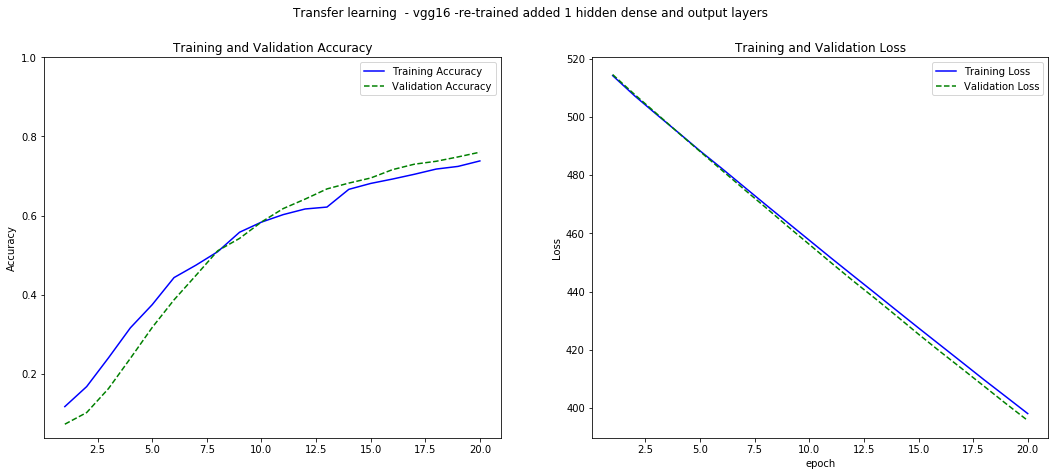

In [38]:
conv_base_resnet50 = VGGFace(input_shape=IMG_SHAPE,model='resnet50',
                             weights='vggface',include_top=False)
conv_base_resnet50.trainable = False


# Regularize the dense layer by using L1
kernel_weight = 0.02
bias_weight = 0.02
hidden_dim =512
resnet50_TL_1layer = Sequential([
    conv_base_resnet50,                       
    keras.layers.Flatten(),
    keras.layers.Dense(hidden_dim, activation='relu', name="FC_1",
        kernel_regularizer=regularizers.l1(kernel_weight), 
        bias_regularizer=regularizers.l1(bias_weight)),
    keras.layers.Dense(11, activation='softmax', name='FC_2',
         kernel_regularizer=regularizers.l1(kernel_weight), 
         bias_regularizer=regularizers.l1(bias_weight))])

# compile
resnet50_TL_1layer.compile(optimizer=keras.optimizers.RMSprop(lr=1e-5),
                     loss='categorical_crossentropy' ,metrics=['accuracy'])
# fit the model using similar hyperparameters as before
step_size_train=train_generator.n//train_generator.batch_size  
history_resnet50_TL_1layer= resnet50_TL_1layer.fit_generator(generator=train_generator,
                                       validation_data=validation_generator,
                                       steps_per_epoch=step_size_train,
                                       epochs=20)

resnet50_TL_1layer.save('resnet50_TL_1layer.h5')
resnet50_TL_1layer.save_weights('resnet50_TL_1layer_weights.h5')
plot_history(history_resnet50_TL_1layer, 'Transfer learning  - Resnet50 - re-trained added 1 hidden dense and output layers')

In [126]:
resnet50_TL_1layer.save('resnet50_TL_1layer.h5')

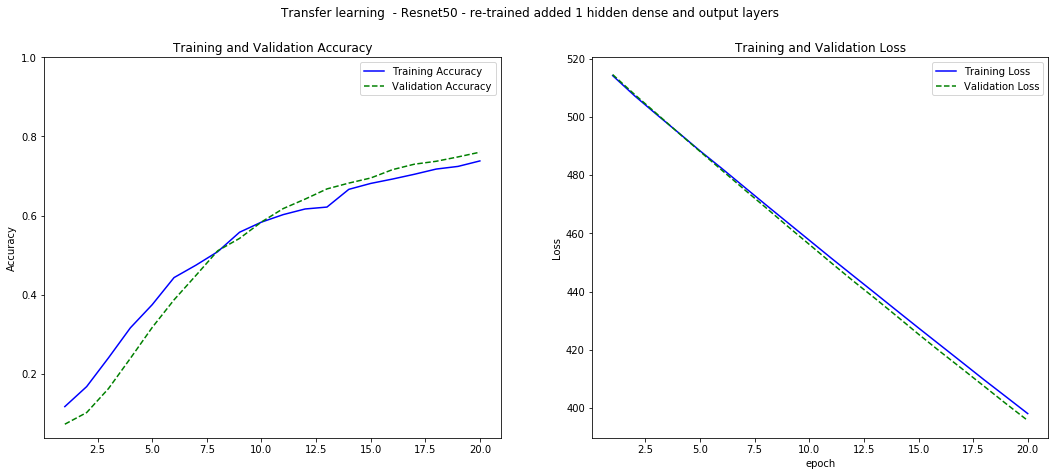

In [111]:
plot_history(history_resnet50_TL_1layer, 'Transfer learning  - Resnet50 - re-trained added 1 hidden dense and output layers')

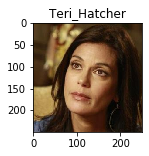

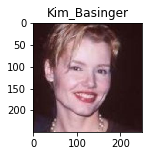

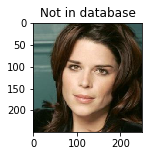

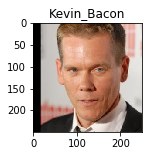

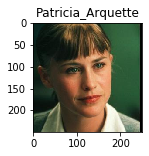

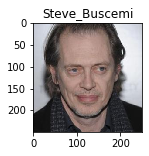

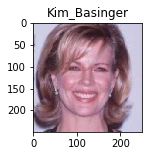

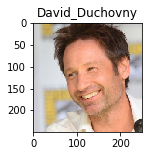

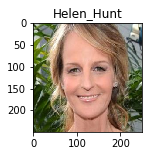

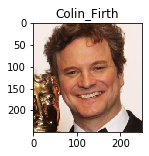

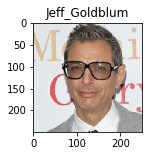

In [125]:

FaceRecognition_testdata(resnet50_TL_1layer, listGroupsTest)

# Added 2 dense and a softmax layer and retrained the added layers:
- Having  conv base layers frozen.

In [41]:
conv_base_resnet50 = VGGFace(input_shape=IMG_SHAPE,model='resnet50',
                             weights='vggface',include_top=False)

In [44]:
conv_base_resnet50.trainable = False
number_groupsTrain = len(listGroupsTrain)
# Regularize the dense layer by using L1
kernel_weight = 0.02
bias_weight = 0.02
hidden_dim =512

resnet50_TL = Sequential([
    conv_base_resnet50,                       # base from resnet50 
    keras.layers.Flatten(),
    keras.layers.Dense(hidden_dim, activation='relu', name="FC_1"),
    keras.layers.Dense(hidden_dim, activation='relu', name="FC_2",
        kernel_regularizer=regularizers.l1(kernel_weight), 
        bias_regularizer=regularizers.l1(bias_weight)),
    keras.layers.Dense(11, activation='softmax', name='FC_3',
        kernel_regularizer=regularizers.l1(kernel_weight), 
        bias_regularizer=regularizers.l1(bias_weight))])

resnet50_TL.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Model)     (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten_71 (Flatten)         (None, 2048)              0         
_________________________________________________________________
FC_1 (Dense)                 (None, 512)               1049088   
_________________________________________________________________
FC_2 (Dense)                 (None, 512)               262656    
_________________________________________________________________
FC_3 (Dense)                 (None, 11)                5643      
Total params: 24,878,539
Trainable params: 1,317,387
Non-trainable params: 23,561,152
_________________________________________________________________


In [45]:
resnet50_TL.compile(optimizer=keras.optimizers.RMSprop(lr=1e-5),
                     loss='categorical_crossentropy' ,metrics=['accuracy'])
step_size_train=train_generator.n//train_generator.batch_size  
history_resnet50_TL = resnet50_TL.fit_generator(generator=train_generator,
                                       validation_data=validation_generator,
                                       steps_per_epoch=step_size_train,
                                       epochs=20)

Epoch 1/20
33/33 [==============================] - 215s 7s/step - loss: 207.9778 - accuracy: 0.1631 - val_loss: 208.5120 - val_accuracy: 0.3085
Epoch 2/20
33/33 [==============================] - 214s 6s/step - loss: 205.5557 - accuracy: 0.3797 - val_loss: 206.1152 - val_accuracy: 0.5308
Epoch 3/20
33/33 [==============================] - 210s 6s/step - loss: 203.5203 - accuracy: 0.5739 - val_loss: 203.9610 - val_accuracy: 0.6841
Epoch 4/20
33/33 [==============================] - 211s 6s/step - loss: 201.5967 - accuracy: 0.6954 - val_loss: 201.9017 - val_accuracy: 0.7778
Epoch 5/20
33/33 [==============================] - 213s 6s/step - loss: 199.7438 - accuracy: 0.7661 - val_loss: 199.7233 - val_accuracy: 0.8411
Epoch 6/20
33/33 [==============================] - 213s 6s/step - loss: 197.9002 - accuracy: 0.8253 - val_loss: 197.6738 - val_accuracy: 0.8788
Epoch 7/20
33/33 [==============================] - 212s 6s/step - loss: 196.1231 - accuracy: 0.8600 - val_loss: 195.7300 - val_ac

In [123]:
resnet50_TL.save('resnet50_TL.h5')
resnet50_TL.save_weights('resnet50_TL_weights.h5')

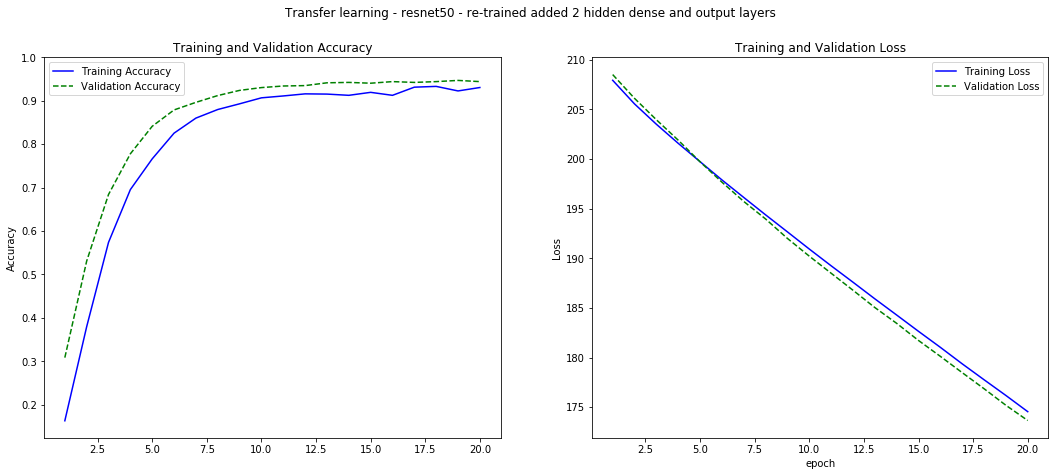

In [103]:
plot_history(history_resnet50_TL, 'Transfer learning - resnet50 - re-trained added 2 hidden dense and output layers')

In [ ]:
#  Create a function that goes through all images in test_dir and predicts them using the specified model:

In [52]:
def FaceRecognition_testdata(model, listGroupsTest):
    i=0
    for celeb in listGroupsTest:
        if not celeb.startswith('.'):
            test_img_path = os.path.join(test_dir, celeb)
            if not test_img_path.startswith('.'):
                for test_img  in os.listdir(test_img_path):
                    if not test_img.startswith('.'):

                        test_identity = 'Not in database'

                        test_img_fullpath = os.path.join(test_img_path, test_img)
                        face = extract_face(test_img_fullpath)
                        face = face.astype('float32')
                        face = expand_dims(face, axis=0)
                        preprocessed_face = preprocess_input(face, version=2)

                        #normalzed the color code
    #                     preprocessed_face = face / 255
                        prediction = model.predict(preprocessed_face)

                        if np.max(prediction) > 0.5:
                            name = np.argmax(prediction, axis=-1)
                            test_identity = listGroupsTest[name[0]]
                        img = cv2.imread(os.path.join(test_img_path, test_img))
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        plt.imshow(img_rgb)
                        plt.title(test_identity)
                        plt.show()
#                         print('test image is : ', test_identity)


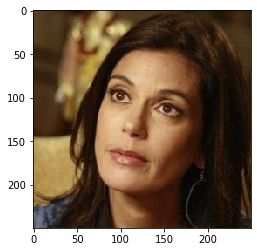

test image is :  Teri_Hatcher


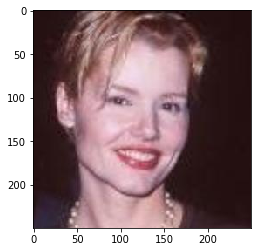

test image is :  Geena_Davis


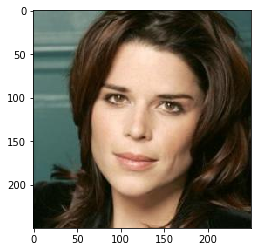

test image is :  Neve_Campbell


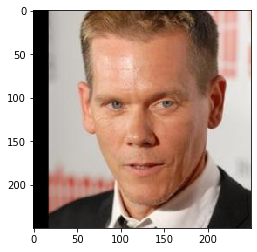

test image is :  Kevin_Bacon


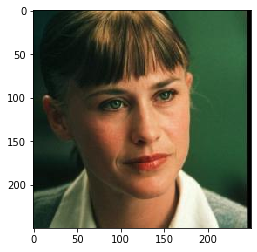

test image is :  Patricia_Arquette


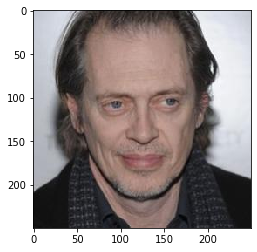

test image is :  Steve_Buscemi


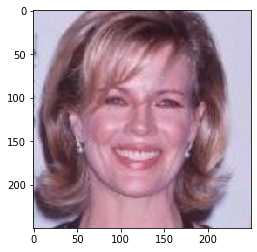

test image is :  Kim_Basinger


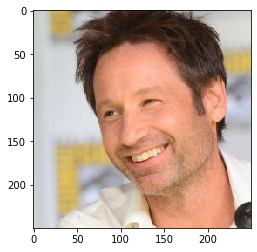

test image is :  David_Duchovny


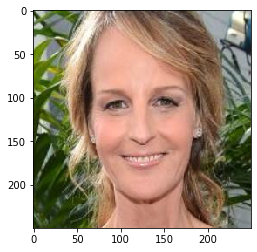

test image is :  Helen_Hunt


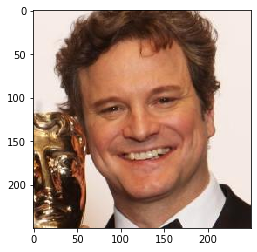

test image is :  Colin_Firth


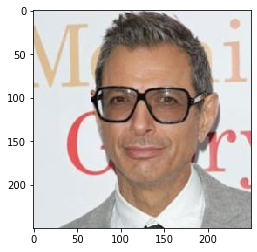

test image is :  Jeff_Goldblum


In [53]:
FaceRecognition_testdata(resnet50_TL, listGroupsTest)

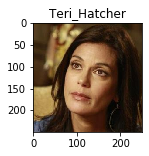

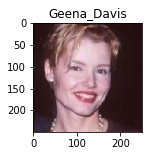

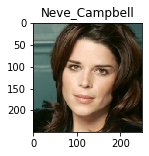

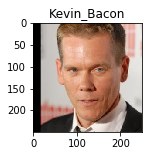

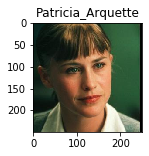

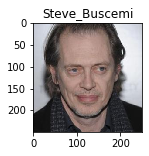

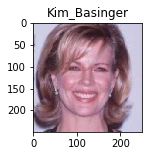

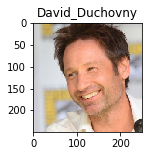

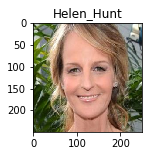

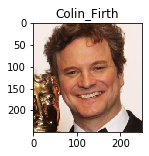

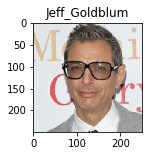

In [122]:
FaceRecognition_testdata(resnet50_TL, listGroupsTest)

# Transfer Learning on VGG16 :


#  Add 1 hidden dense and output layer on the convolutional base and retrain added layers:
- Having  conv base layers frozen.

In [106]:
conv_base_vgg = VGGFace(input_shape=IMG_SHAPE,model='vgg16',
                        weights='vggface',include_top=False)

Epoch 1/20
33/33 [==============================] - 284s 9s/step - loss: 1946.8883 - accuracy: 0.3590 - val_loss: 1917.3114 - val_accuracy: 0.7006
Epoch 2/20
33/33 [==============================] - 304s 9s/step - loss: 1886.3787 - accuracy: 0.6704 - val_loss: 1854.4717 - val_accuracy: 0.8301
Epoch 3/20
33/33 [==============================] - 312s 9s/step - loss: 1828.0357 - accuracy: 0.7608 - val_loss: 1795.4243 - val_accuracy: 0.8724
Epoch 4/20
33/33 [==============================] - 321s 10s/step - loss: 1767.4123 - accuracy: 0.8162 - val_loss: 1734.4683 - val_accuracy: 0.8972
Epoch 5/20
33/33 [==============================] - 320s 10s/step - loss: 1705.9247 - accuracy: 0.8414 - val_loss: 1672.7388 - val_accuracy: 0.8972
Epoch 6/20
33/33 [==============================] - 315s 10s/step - loss: 1643.9116 - accuracy: 0.8488 - val_loss: 1611.1769 - val_accuracy: 0.9238
Epoch 7/20
33/33 [==============================] - 318s 10s/step - loss: 1582.0651 - accuracy: 0.8705 - val_loss: 

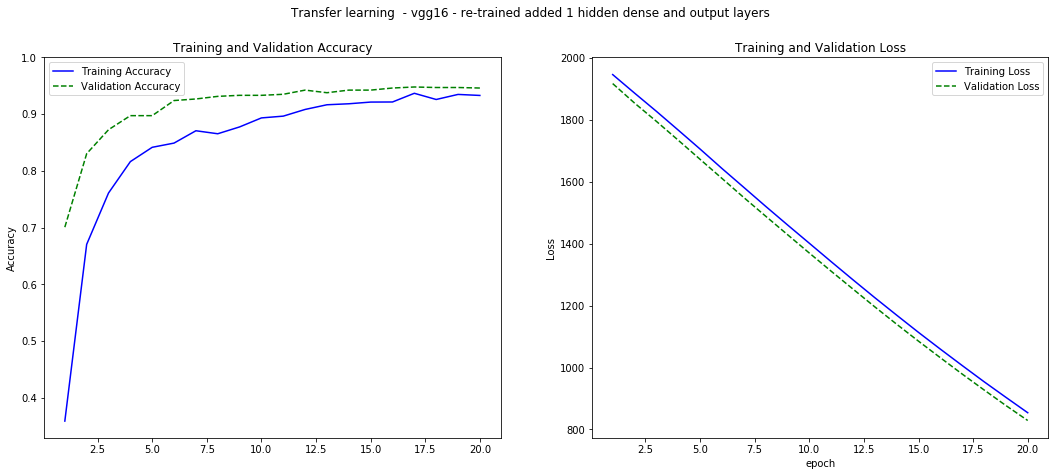

In [60]:
conv_base_vgg.trainable = False
# Regularize the dense layer by using L1
kernel_weight = 0.02
bias_weight = 0.02
hidden_dim =512

vgg16_TL_1layer = Sequential([
    conv_base_vgg,                       
    keras.layers.Flatten(),
    keras.layers.Dense(hidden_dim, activation='relu', name="FC_1",
        kernel_regularizer=regularizers.l1(kernel_weight), 
        bias_regularizer=regularizers.l1(bias_weight)),
    keras.layers.Dense(11, activation='softmax', name='FC_2',
         kernel_regularizer=regularizers.l1(kernel_weight), 
         bias_regularizer=regularizers.l1(bias_weight))])


vgg16_TL_1layer.compile(optimizer=keras.optimizers.RMSprop(lr=1e-5),
                     loss='categorical_crossentropy' ,metrics=['accuracy'])
step_size_train=train_generator.n//train_generator.batch_size  
history_vgg16_TL_1layer= vgg16_TL_1layer.fit_generator(generator=train_generator,
                                       validation_data=validation_generator,
                                       steps_per_epoch=step_size_train,
                                       epochs=20)

vgg16_TL_1layer.save('vgg16_TL_1layer.h5')
vgg16_TL_1layer.save_weights('vgg16_TL_1layer_weights.h5')
plot_history(history_vgg16_TL_1layer, 'Transfer learning  - vgg16 - re-trained added 1 hidden dense and output layers')

#  Add 2 hidden dense layers and output layer on the convolutional base and retrain added layers:
- having  conv base layers frozen.

In [62]:
conv_base_vgg = VGGFace(input_shape=IMG_SHAPE,model='vgg16',weights='vggface',include_top=False)
conv_base_vgg.trainable = False

# Regularize the dense layer by using L1
kernel_weight = 0.02
bias_weight = 0.02
hidden_dim =512
vgg16_TL = Sequential([
    conv_base_vgg,                       
    keras.layers.Flatten(),
    keras.layers.Dense(hidden_dim, activation='relu', name="FC_1",
        kernel_regularizer=regularizers.l1(kernel_weight), 
        bias_regularizer=regularizers.l1(bias_weight)),
    keras.layers.Dense(hidden_dim, activation='relu', name="FC_2",
        kernel_regularizer=regularizers.l1(kernel_weight), 
        bias_regularizer=regularizers.l1(bias_weight)),
    keras.layers.Dense(11, activation='softmax', name='FC_3',
         kernel_regularizer=regularizers.l1(kernel_weight), 
         bias_regularizer=regularizers.l1(bias_weight))])
vgg16_TL.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_vgg16 (Model)        (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_96 (Flatten)         (None, 25088)             0         
_________________________________________________________________
FC_1 (Dense)                 (None, 512)               12845568  
_________________________________________________________________
FC_2 (Dense)                 (None, 512)               262656    
_________________________________________________________________
FC_3 (Dense)                 (None, 11)                5643      
Total params: 27,828,555
Trainable params: 13,113,867
Non-trainable params: 14,714,688
_________________________________________________________________


In [64]:
vgg16_TL.compile(optimizer=keras.optimizers.RMSprop(lr=1e-5),
                     loss='categorical_crossentropy' ,metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size  

history_vgg16_TL= vgg16_TL.fit_generator(generator=train_generator,
                                       validation_data=validation_generator,
                                       steps_per_epoch=step_size_train,
                                       epochs=20)

Epoch 1/20
33/33 [==============================] - 325s 10s/step - loss: 2137.6640 - accuracy: 0.3373 - val_loss: 2098.7161 - val_accuracy: 0.5840
Epoch 2/20
33/33 [==============================] - 333s 10s/step - loss: 2070.4592 - accuracy: 0.6304 - val_loss: 2035.2307 - val_accuracy: 0.7429
Epoch 3/20
33/33 [==============================] - 334s 10s/step - loss: 2005.0398 - accuracy: 0.6998 - val_loss: 1969.5917 - val_accuracy: 0.8255
Epoch 4/20
33/33 [==============================] - 317s 10s/step - loss: 1938.6780 - accuracy: 0.7681 - val_loss: 1903.1599 - val_accuracy: 0.8540
Epoch 5/20
33/33 [==============================] - 324s 10s/step - loss: 1871.7089 - accuracy: 0.7973 - val_loss: 1836.0433 - val_accuracy: 0.8669
Epoch 6/20
33/33 [==============================] - 348s 11s/step - loss: 1804.1800 - accuracy: 0.8253 - val_loss: 1768.8500 - val_accuracy: 0.8880
Epoch 7/20
33/33 [==============================] - 343s 10s/step - loss: 1737.2965 - accuracy: 0.8439 - val_los

In [65]:
vgg16_TL.save('vgg16_TL.h5')
vgg16_TL.save_weights('vgg16_TL_weights.h5')

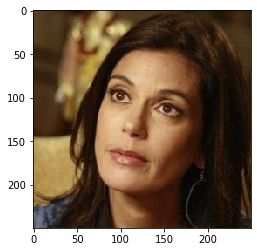

test image is :  Teri_Hatcher


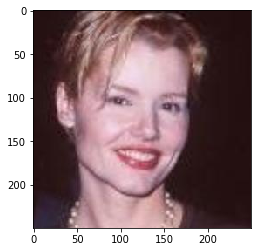

test image is :  Geena_Davis


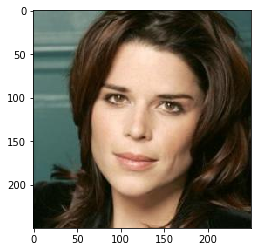

test image is :  Neve_Campbell


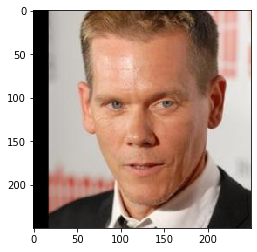

test image is :  Kevin_Bacon


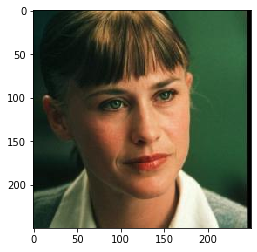

test image is :  Colin_Firth


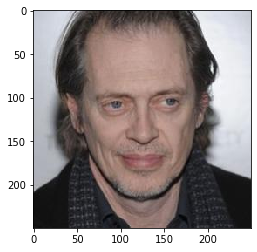

test image is :  Steve_Buscemi


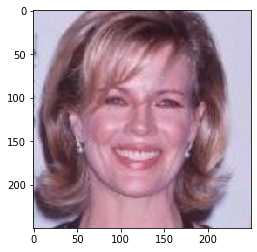

test image is :  Kim_Basinger


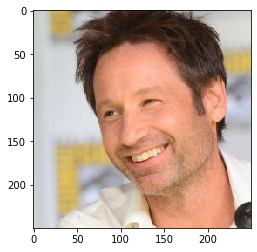

test image is :  David_Duchovny


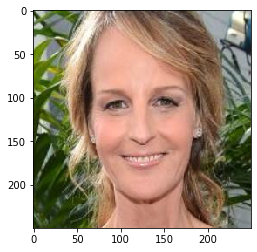

test image is :  Kim_Basinger


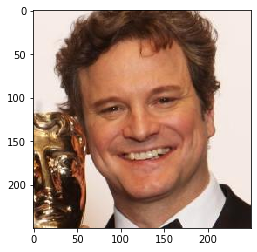

test image is :  Colin_Firth


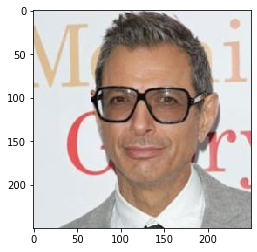

test image is :  Jeff_Goldblum


In [66]:
# vgg16_TL = load_model('vgg16_TL.h5')
FaceRecognition_testdata(vgg16_TL, listGroupsTest)

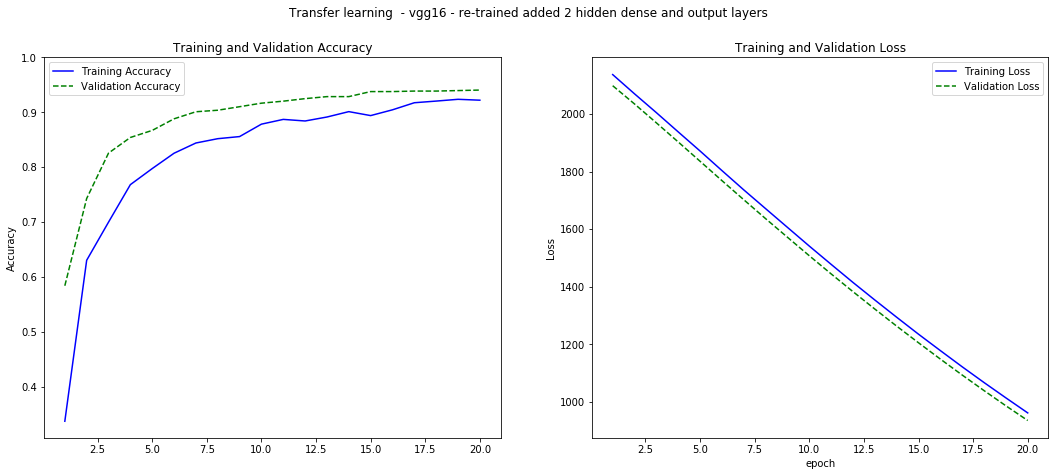

In [67]:

plot_history(history_vgg16_TL, 'Transfer learning  - vgg16 - re-trained added 2 hidden dense and output layers ')

# Report:

-  Adding 2 hidden dense layers versus 1 hidden dense layer significantly improved the accuracy and the performance of the model created on Resnet50's convolutional base (val acc increased from approximately 76% to approximately 94%).

- However, in the case of models using VGG16's convolutional base, the accuracy of the performance in both cases are ~ 94%

- Validation and training accuracy and loss change together with a slight difference. The model is neither overfitting not underfitting

- 20 epochs seems to be a good choice since loss has been decreasing and train and validation accuracy are very close. Neither overfitting or underfitting.





#  Fine tunning

- Build a model on top of the convolutional base of the VGG16 and ResNet50
- Unfreeze the parameters of all layers in the last convolutional block
- The remaining layers in convolutional base are frozen
- Train parameters in the last convolutional block, added dense and classification layers
- Use regularizes for regularization to avoid overfitting


# Fine Tuning on ResNet50:

In [72]:
conv_base_resnet_FT = VGGFace(input_shape=
                                        IMG_SHAPE, model='resnet50',weights='vggface', include_top=False)

# The number of the layers in the base model
NumOfLayers = len(conv_base_resnet_FT.layers)
print("Number of layers in the base model: ", NumOfLayers)

Number of layers in the base model:  174


In [74]:
conv_base_resnet_FT.trainable = True
for layer in conv_base_resnet_FT.layers[0:141]:
    layer.trainable =  False
    i+=1

In [76]:
number_groupsTrain = len(listGroupsTrain)
# Regularize the dense layer by using L1
kernel_weight = 0.02
bias_weight = 0.02
hidden_dim =512

resnet50_FT = Sequential([
    conv_base_resnet_FT,
    keras.layers.Flatten(),
    keras.layers.Dense(hidden_dim, activation='relu', name="FC_1",
                kernel_regularizer=regularizers.l1(kernel_weight), 
                bias_regularizer=regularizers.l1(bias_weight)),
    keras.layers.Dense(11, activation='softmax', name='FC_2',
                kernel_regularizer=regularizers.l1(kernel_weight), 
                bias_regularizer=regularizers.l1(bias_weight))
])
resnet50_FT.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Model)     (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten_145 (Flatten)        (None, 2048)              0         
_________________________________________________________________
FC_1 (Dense)                 (None, 512)               1049088   
_________________________________________________________________
FC_2 (Dense)                 (None, 11)                5643      
Total params: 24,615,883
Trainable params: 16,019,467
Non-trainable params: 8,596,416
_________________________________________________________________


In [77]:
resnet50_FT.compile(optimizer=keras.optimizers.RMSprop(lr=1e-5),
                     loss='categorical_crossentropy' ,metrics=['accuracy'])
step_size_train=train_generator.n//train_generator.batch_size
history_resnet50_FT= resnet50_FT.fit_generator(generator=train_generator,
                                                  validation_data=validation_generator,
                                                  steps_per_epoch=step_size_train,
                                                  epochs=20)

Epoch 1/20
33/33 [==============================] - 251s 8s/step - loss: 511.0422 - accuracy: 0.5746 - val_loss: 507.4561 - val_accuracy: 0.8118
Epoch 2/20
33/33 [==============================] - 272s 8s/step - loss: 503.1316 - accuracy: 0.8561 - val_loss: 499.3997 - val_accuracy: 0.8999
Epoch 3/20
33/33 [==============================] - 284s 9s/step - loss: 496.2203 - accuracy: 0.9148 - val_loss: 492.4884 - val_accuracy: 0.9284
Epoch 4/20
33/33 [==============================] - 279s 8s/step - loss: 489.4308 - accuracy: 0.9283 - val_loss: 485.7546 - val_accuracy: 0.9403
Epoch 5/20
33/33 [==============================] - 271s 8s/step - loss: 482.6761 - accuracy: 0.9504 - val_loss: 479.0760 - val_accuracy: 0.9541
Epoch 6/20
33/33 [==============================] - 271s 8s/step - loss: 476.0086 - accuracy: 0.9490 - val_loss: 472.4304 - val_accuracy: 0.9587
Epoch 7/20
33/33 [==============================] - 260s 8s/step - loss: 469.3557 - accuracy: 0.9615 - val_loss: 465.8300 - val_ac

In [78]:
resnet50_FT.save('resnet50_FT.h5')
resnet50_FT.save_weights('resnet50_FT_weights.h5')

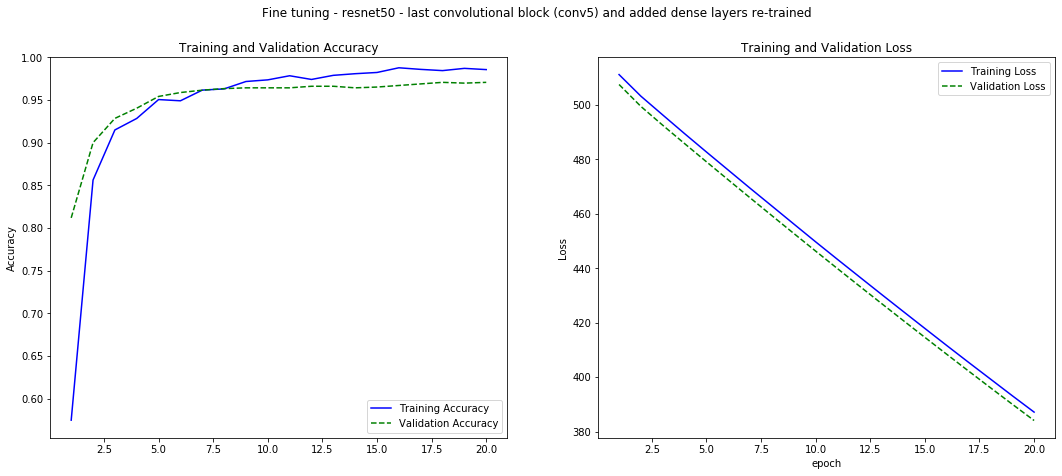

In [79]:
plot_history(history_resnet50_FT, 'Fine tuning - resnet50 - last convolutional block (conv5) and added dense layers re-trained')

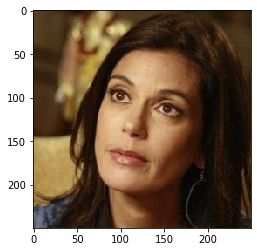

test image is :  Teri_Hatcher


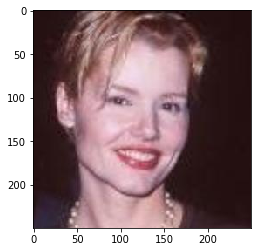

test image is :  Geena_Davis


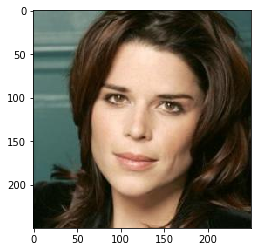

test image is :  Neve_Campbell


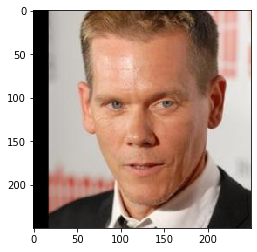

test image is :  Kevin_Bacon


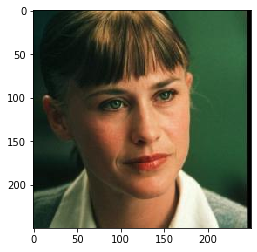

test image is :  Patricia_Arquette


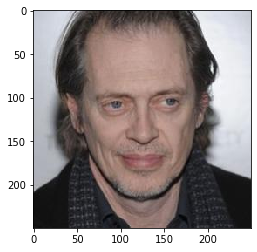

test image is :  Steve_Buscemi


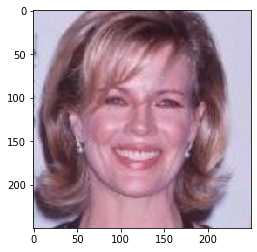

test image is :  Kim_Basinger


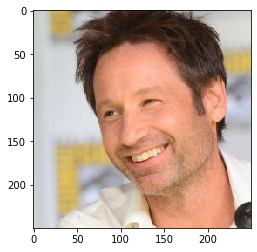

test image is :  David_Duchovny


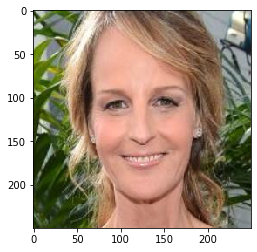

test image is :  Helen_Hunt


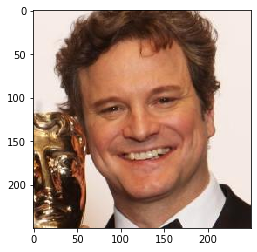

test image is :  Colin_Firth


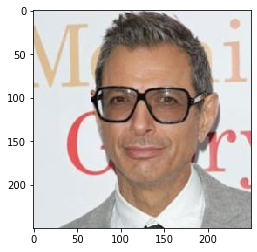

test image is :  Jeff_Goldblum


In [80]:
FaceRecognition_testdata(resnet50_FT, listGroupsTest)

# Fine Tuning on VGG16:

In [107]:
# Fine-tune only the last convolution
conv_base_vgg_FT = VGGFace(input_shape=
                                        IMG_SHAPE, model='vgg16',weights='vggface', include_top=False)

In [88]:
# The number of the layers in the base model
NumOfLayers = len(conv_base_vgg_FT.layers)
print("Number of layers in the base model: ", NumOfLayers)


Number of layers in the base model:  19


In [90]:
number_groupsTrain = len(listGroupsTrain)
# Regularize the dense layer by using L1
kernel_weight = 0.02
bias_weight = 0.02
hidden_dim =512
vgg16_FT = Sequential([
      conv_base_vgg_FT,
      keras.layers.Flatten(),
    keras.layers.Dense(hidden_dim, activation='relu', name="FC_1",
                    kernel_regularizer=regularizers.l1(kernel_weight), 
                    bias_regularizer=regularizers.l1(bias_weight)),
 keras.layers.Dense(11, activation='softmax', name='FC_2',#)])
                    kernel_regularizer=regularizers.l1(kernel_weight), 
                    bias_regularizer=regularizers.l1(bias_weight))])
vgg16_FT.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_vgg16 (Model)        (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_169 (Flatten)        (None, 25088)             0         
_________________________________________________________________
FC_1 (Dense)                 (None, 512)               12845568  
_________________________________________________________________
FC_2 (Dense)                 (None, 11)                5643      
Total params: 27,565,899
Trainable params: 27,565,899
Non-trainable params: 0
_________________________________________________________________


In [91]:
conv_base_vgg_FT.trainable = True
for layer in conv_base_vgg_FT.layers[0:15]:
    layer.trainable =  False
    i+=1

In [92]:
for layer in conv_base_vgg_FT.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x1ae413e7d0> False
<keras.layers.convolutional.Conv2D object at 0x1ae413e910> False
<keras.layers.convolutional.Conv2D object at 0x1ae7898290> False
<keras.layers.pooling.MaxPooling2D object at 0x1ae413ec10> False
<keras.layers.convolutional.Conv2D object at 0x1ae20cd0d0> False
<keras.layers.convolutional.Conv2D object at 0x1ae4145ad0> False
<keras.layers.pooling.MaxPooling2D object at 0x1ae212aed0> False
<keras.layers.convolutional.Conv2D object at 0x1ae20b8ed0> False
<keras.layers.convolutional.Conv2D object at 0x1ae414af90> False
<keras.layers.convolutional.Conv2D object at 0x1ae4150f10> False
<keras.layers.pooling.MaxPooling2D object at 0x1ae4156590> False
<keras.layers.convolutional.Conv2D object at 0x1ae415c590> False
<keras.layers.convolutional.Conv2D object at 0x1ae4161710> False
<keras.layers.convolutional.Conv2D object at 0x1ae4167e90> False
<keras.layers.pooling.MaxPooling2D object at 0x1ae41679d0> False
<keras.layers.convoluti

In [93]:
vgg16_FT.compile(optimizer=keras.optimizers.RMSprop(lr=1e-5),
                     loss='categorical_crossentropy' ,metrics=['accuracy'])
step_size_train=train_generator.n//train_generator.batch_size
history_vgg16_FT= vgg16_FT.fit_generator(generator=train_generator,
                                                  validation_data=validation_generator,
                                                  steps_per_epoch=step_size_train,
                                                  epochs=20)

Epoch 1/20
33/33 [==============================] - 345s 10s/step - loss: 1941.9436 - accuracy: 0.4346 - val_loss: 1904.2771 - val_accuracy: 0.7355
Epoch 2/20
33/33 [==============================] - 371s 11s/step - loss: 1876.6668 - accuracy: 0.7026 - val_loss: 1842.2394 - val_accuracy: 0.8356
Epoch 3/20
33/33 [==============================] - 395s 12s/step - loss: 1811.9191 - accuracy: 0.7873 - val_loss: 1776.3794 - val_accuracy: 0.8733
Epoch 4/20
33/33 [==============================] - 399s 12s/step - loss: 1744.4469 - accuracy: 0.8426 - val_loss: 1708.4407 - val_accuracy: 0.8898
Epoch 5/20
33/33 [==============================] - 395s 12s/step - loss: 1676.2930 - accuracy: 0.8460 - val_loss: 1640.5051 - val_accuracy: 0.9036
Epoch 6/20
33/33 [==============================] - 401s 12s/step - loss: 1608.2639 - accuracy: 0.8624 - val_loss: 1572.8936 - val_accuracy: 0.9118
Epoch 7/20
33/33 [==============================] - 400s 12s/step - loss: 1540.6393 - accuracy: 0.8898 - val_los

In [94]:
vgg16_FT.save('vgg16_FT.h5')
vgg16_FT.save_weights('vgg16_FT_weights.h5')

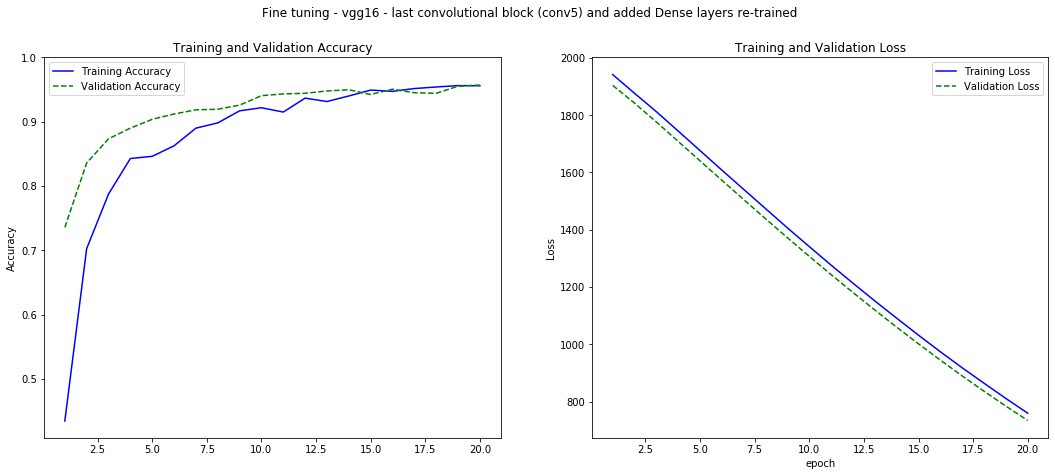

In [96]:
plot_history(history_vgg16_FT, 'Fine tuning - vgg16 - last convolutional block (conv5) and added Dense layers re-trained')

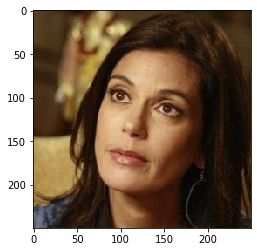

test image is :  Teri_Hatcher


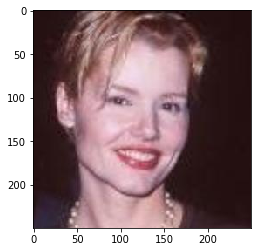

test image is :  Geena_Davis


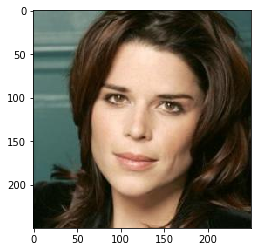

test image is :  Neve_Campbell


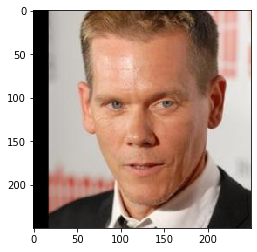

test image is :  Kevin_Bacon


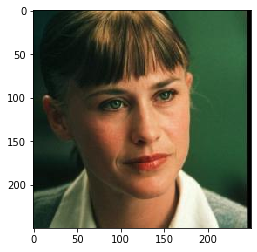

test image is :  Patricia_Arquette


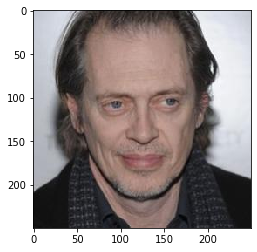

test image is :  Steve_Buscemi


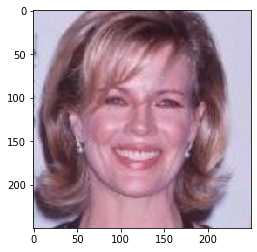

test image is :  Kim_Basinger


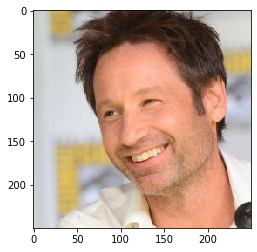

test image is :  David_Duchovny


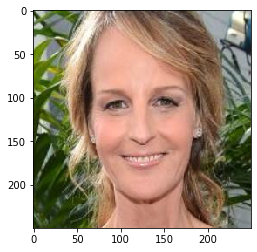

test image is :  Helen_Hunt


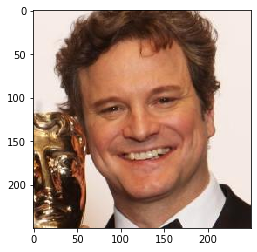

test image is :  Colin_Firth


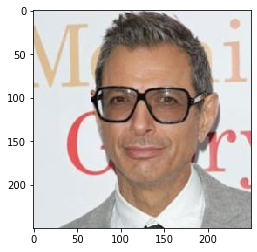

test image is :  Jeff_Goldblum


In [97]:
FaceRecognition_testdata(vgg16_FT, listGroupsTest)

#  Report:


- Finetuning improved the performance accuracies more than transfer learning in models using both architectures

- Model using VGG16 convolutional base responded better than ReNet50 to the transfer learning regardless of the 1 or 2 layers added ( with accuracy ~93%. val-acc ~94%). Model using ReNet50 convolutional base only compensated to the same accuracy when 2  hidden dense layers were added 

- Model using Resnet50 convolutional base responded to finetuning as both the training and validation accuracy increased to approximately 98%. 


# Highlight and Explanation of Reports:

1.	Repurposing existing models, using a moderate size dataset, to match an extracted face to a known individual can significantly improve the prediction accuracy of pretrained models.
2.	The performance of repurposed models strongly depends on the underlying network architecture and not necessarily the depth or number of layers. VGG16 yields higher validation accuracy with less layers retrained. VGG16 and Resnet50 models are both pretrained on the same VGGFace2 dataset. However, when more of the layers are retrained, model using ResNet50 improved more.
3.	Fine tuning improved the validation accuracies more than transfer learning in models created VGG16 and ResNet50’s convolutional base.
4.	Models using VGG16’s convolutional base responded better than ReNet50 to the transfer learning regardless of the 1 or 2 layers added. Models using ReNet50’s convolutional base only compensated to the same accuracy when 2  hidden dense layers were added.
5.	Model using Resnet50’s convolutional base responded better than VGG16 to finetuning. (model using VGG16 convolutional base improved from ~93% in TL to ~ 95% in FT, while using Resnet50 improved from ~93% in TL to ~97% in FT)
6.	Models in Transfer learning and finetuning provided a better fit than models created using extracted features. In transfer learning and fine tuning sections, training and validation accuracy improved together and remain very close. Models are neither overfitting nor underfitting. On the other hand, in the models created using extracted features, the validation accuracy remain less training accuracy. 
7.	The performance of repurposed models strongly depends on the number of images in the underlying datasets of pretrained models, as FaceNet with 1 million identities strongly over performs VGG16 and ResNet50 with 9,131 identities.
8.	The initial dataset used to train them and not necessarily the depth or number of layers. 
